In [1]:
from time import perf_counter_ns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from adaptvqe.pools import FullPauliPool, TiledPauliPool
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt
from adaptvqe.hamiltonians import XXZHamiltonian

In [6]:
dmrg_mpo_bond = 100
dmrg_mps_bond = 10
pool_mpo_bond = 100
adapt_mpo_bond = 100
adapt_mps_bond = 10

system_sizes = list(range(2, 14, 2))

In [7]:
linalg_times = {}
tn_times = {}

for l in system_sizes:
    print(f"l = {l}")
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=dmrg_mpo_bond, max_mps_bond=dmrg_mps_bond)
    pool = FullPauliPool(n=l)

    # Generate indices and coefficients randomly.
    inds = np.random.randint(0, len(pool.operators), size=10)
    coeffs = np.random.rand(len(inds))

    start_time = perf_counter_ns()
    linalg_adapt = LinAlgAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    state = linalg_adapt.compute_state(coefficients=coeffs, indices=inds)
    end_time = perf_counter_ns()
    linalg_times[l] = end_time - start_time

    start_time = perf_counter_ns()
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    state = tn_adapt.compute_state(coefficients=coeffs, indices=inds)
    end_time = perf_counter_ns()
    tn_times[l] = end_time - start_time

l = 2
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
l = 4
l = 6
l = 8
l = 10
l = 12


In [8]:
records = []
for l in system_sizes:
    records.append((l, linalg_times[l], tn_times[l]))
df = pd.DataFrame.from_records(records, columns=["l", "linalg_time", "tn_time"])
df.set_index("l", inplace=True)

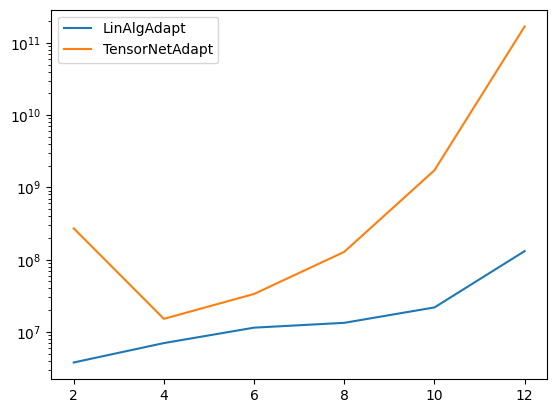

In [9]:
fig, ax = plt.subplots()
ax.plot(df.index, df["linalg_time"], label="LinAlgAdapt")
ax.plot(df.index, df["tn_time"], label="TensorNetAdapt")
ax.set_yscale("log")
ax.legend()